# In-Depth: Decision Trees and Random Forests

- Random forests are an example of an *ensemble* method, meaning that it relies on aggregating the results of an ensemble of simpler estimators. The sum can be greater than the parts: that is, a majority vote among a number of estimators can end up being better than any of the individual estimators.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### Decision Tree Basics

- Random forests are an example of an *ensemble learner* built on decision trees.
- Decision trees are intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification. To build a decision tree to classify an animal, you might do this:

![](figures/05.08-decision-tree.png)

- Binary splitting makes this extremely efficient. Each question in a well-constructed tree will cut the number of options by approximately half, which quickly narrows the options even among a large number of classes.
- Decision tree questions generally take the form of axis-aligned splits in the data. Each node splits the data into two groups using a cutoff value within one of the features.

### Creating a decision tree

Consider the following two-dimensional data, which has one of four class labels:

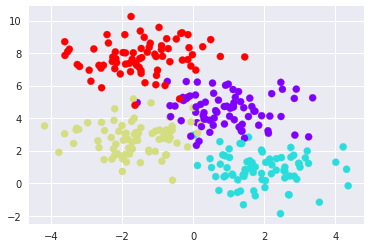

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

- A decision tree iteratively splits the data along an axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it. Here's the visual of the first four levels.
- Notice that after the first split, every point in the upper branch remains unchanged. (There is no need to further subdivide this branch.)
- Except for nodes that contain all of one color, at each level *every* region is again split along one of the two features.

![](figures/05.08-decision-tree-levels.png)

- Scikit-Learn uses the ``DecisionTreeClassifier`` estimator.

In [3]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

- This helps visualize the output of the classifier:

In [4]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, # clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

- View it.

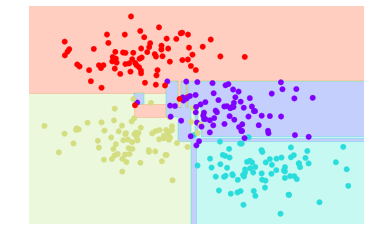

In [5]:
visualize_classifier(DecisionTreeClassifier(), X, y)

- If you're running this notebook live, you can use the helpers script included in [The Online Appendix](06.00-Figure-Code.ipynb#Helper-Code) to bring up an interactive visualization of the decision tree building process:

In [6]:
# helpers_05_08 is found in the online appendix
import helpers_05_08
helpers_05_08.plot_tree_interactive(X, y);

A Jupyter Widget

- Note: as the depth increases, we tend to get very strangely shaped classification regions. (Example: at depth=5 there is a tall and skinny purple region between the yellow and blue regions.)
- This is less a result of the true, intrinsic data distribution, and more a result of the sampling or noise properties of the data. Our decision tree, even at only five levels deep, is over-fitting our data.

### Decision trees and over-fitting

- Over-fitting is a common property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of specific data rather than the overall properties of the distributions. Another way to see this issue is to look at models trained on different subsets of the data.
- Below are the results of training two different trees, each on half of the original data:

![](figures/05.08-decision-tree-overfitting.png)

- In some cases the two trees produce consistent results (e.g., in the four corners), while in other places, the two trees give very different classifications (e.g., in the regions between any two clusters).
- Key point: inconsistencies tend to happen where the classification is less certain, and thus by using information from *both* of these trees, we might come up with a better result.

If you are running this notebook live, the following function will allow you to interactively display the fits of trees trained on a random subset of the data:

In [7]:
# helpers_05_08 is found in the online appendix
import helpers_05_08
helpers_05_08.randomized_tree_interactive(X, y)

A Jupyter Widget

### Ensembles of Estimators: Random Forests

- The concept of using multiple overfitting estimators to reduce overfit is the basis for an ensemble method called *bagging*. Bagging uses an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification. An ensemble of randomized decision trees is known as a *random forest*.

- This type of bagging classification can be done using Scikit-Learn's ``BaggingClassifier`` meta-estimator.

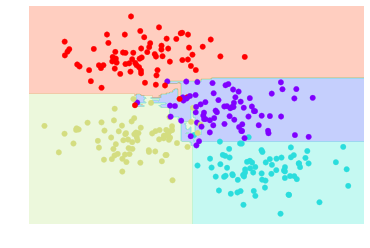

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

- In this example we randomized the data by fitting each estimator with a random subset of 80% of the training points.

- In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness. For example, when determining which feature to split, the randomized tree might select from among the top several features. See more about randomization strategies in the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest).

- An optimized ensemble of randomized decision trees is implemented in the ``RandomForestClassifier`` estimator, which takes care of all the randomization automatically. You simply select the number of estimators.

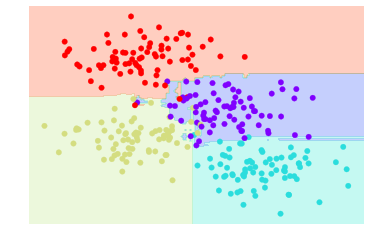

In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

- By averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition.

### Random Forest Regression

- Random forests also work with regressions (that is, continuous rather than categorical variables). We'll use the ``RandomForestRegressor`` method.
- The following data is the combination of a fast and slow oscillation:

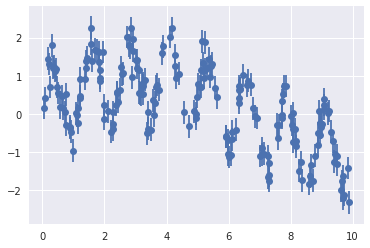

In [10]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

- Find the best fit curve using the Random Forest regressor.

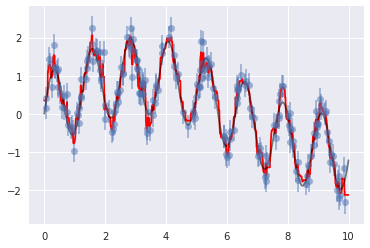

In [11]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

### Example: Random Forest for Classifying Digits
- Let's reuse the hand-written digits dataset here to see how the random forest classifier can be used.

In [12]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

- View the first few data points:

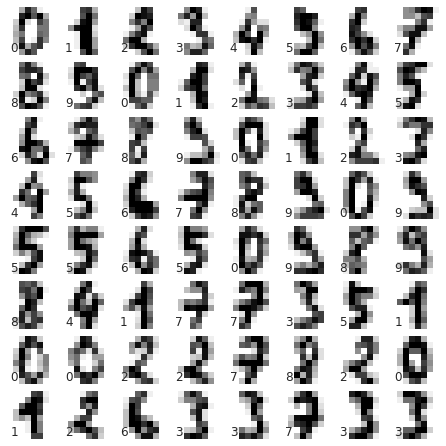

In [13]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.15, wspace=0.15)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

- Classify the digits using a random forest.

In [14]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

- View the classification report and confusion matrix for this classifier.

In [15]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99        38
          1       0.98      0.98      0.98        43
          2       0.95      1.00      0.98        42
          3       0.98      0.96      0.97        46
          4       0.97      1.00      0.99        37
          5       0.98      0.96      0.97        49
          6       1.00      1.00      1.00        52
          7       1.00      0.96      0.98        50
          8       0.94      0.98      0.96        46
          9       0.98      0.98      0.98        47

avg / total       0.98      0.98      0.98       450



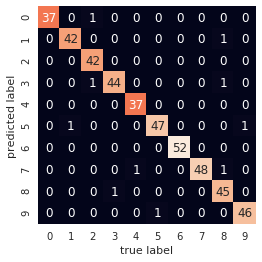

In [16]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

- Not bad!

### Summary of Random Forests

- Advantages:
    - Both training and prediction are very fast due to simplicity of the data. 
    - Both tasks can be straightforwardly parallelized (individual trees are independent entities).
    - Multiple trees allow for a probabilistic classification: a majority vote gives an estimate of the probability (using the ``predict_proba()`` method).
    - The nonparametric model is extremely flexible, and can thus perform well on tasks that are under-fit by other estimators.

- Disadvantages:
    - Results are not easily interpretable. If you would like to draw conclusions about the *meaning* of the classification model, random forests may not be the best choice.